# Clean the test set
- The test set split we made hasn't been cleaned of mis-labelled samples yet. 
- There is also a set of single species recordings stored in SingleSpecies_all.csv, which contains human verified examples of the target species. 



# Clips will be listened to and labelled with the following confidence categories:

Confidence scores:
- 0 UNCHECKED means it hasn't been verified
- 1 DISCARD is something to throw out, 
- 2 UNSURE is not sure
- 3 VERIFIED means the label is definitely correct
- 4 FOCAL means the present label is correct and the target species vocalization is prominent
- 5 Label needs changing from absent to present 
- 6 Label needs changing from present to absent

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
BASE_PATH = Path.cwd().parent.parent
data_path = BASE_PATH / "data"
model_save_path = BASE_PATH / "models"
sys.path.append(str(BASE_PATH))
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram
from opensoundscape.preprocess.utils import show_tensor
from src.utils import verify_samples, plot_locations
from src.data import build


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load the test set
test_df = pd.read_pickle(data_path / "interim" / "test_set" / "test_set.pkl")
test_ds = test_df[["target_present"]]
test_df.target_present.value_counts()

target_present
0.0    10596
1.0     1011
Name: count, dtype: int64

In [4]:
# Load the target species examples from the external test set
ext_df = pd.read_csv(data_path / "raw" / "test_set" / "SingleSpecies_all.csv", low_memory=False)
osfls = ext_df.loc[ext_df.species_code == "OSFL"]

Download the recordings referenced in the external test set which are not yet saved to disk

The file download function requires a couple of extra columns besides the recording URL: the filename and file extension. 

In [7]:
recording_save_path = data_path / "raw" / "recordings" / "OSFL"

def get_file_extension(url):
    file_type = url.split('.')[-1]
    return file_type
def make_filename(df):
    return f"recording-{df.recording_id}.{df.file_type}"

osfls['file_type'] = osfls['recording_url'].apply(get_file_extension)
osfls['filename'] = osfls.apply(make_filename, axis=1)

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_92331/2295812690.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  osfls['file_type'] = osfls['recording_url'].apply(get_file_extension)
/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_92331/2295812690.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  osfls['filename'] = osfls.apply(make_filename, axis=1)


In [8]:
build.download_recordings.from_url(osfls,'recording_url', recording_save_path)

downloading 48 clips
skipped 48 previously downloaded files


Save some 3 second clips containing the target audio. 

In [10]:
present_save_path = data_path / "interim" / "test_set" / "present" 
present_save_path.mkdir(exist_ok=True, parents=True)
for i, row in osfls.iterrows():
    present = Audio.from_file(recording_save_path / row.filename, offset=row.detection_time, duration=3.0)
    present.save(present_save_path / f"OSFL_test_present_{i}.{row.file_type}", suppress_warnings=True)

# Check the locations of the test set


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:277: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(
/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:277: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


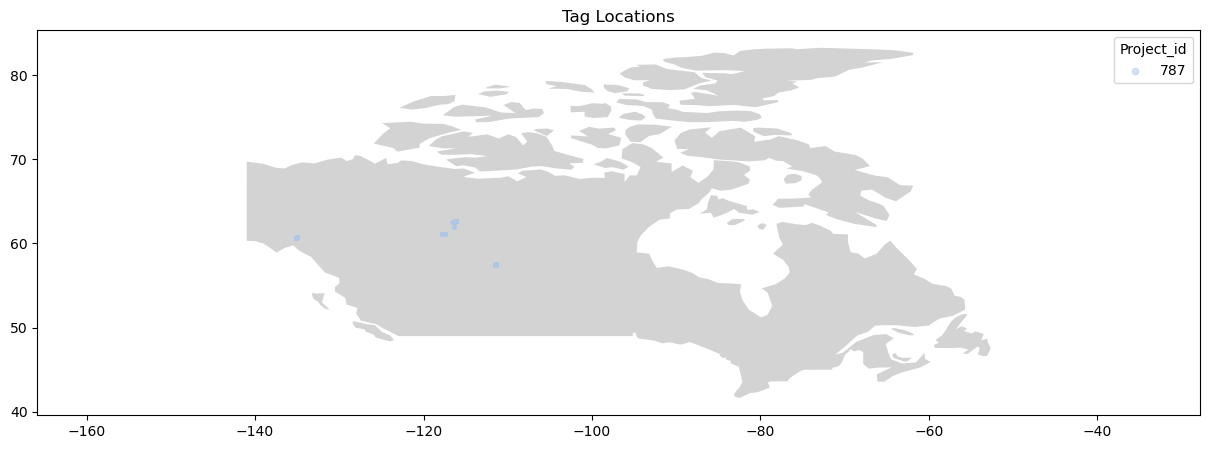

In [11]:
plot_locations(osfls, feature='project_id')

It looks as though the spread of locations in the test set isn't very wide - there are four tight clusters of locations. Therefore this test set can not be used as an indicator of model performance across a wide set of locations. 

# Process the test set created during train/valid/split in the same ways the validation set was processed

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:277: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  points.plot(


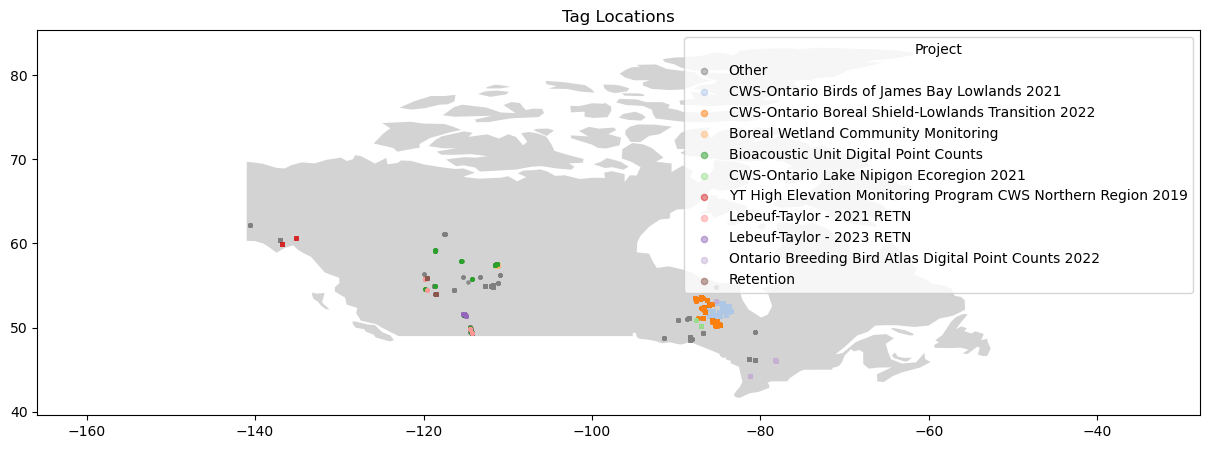

In [35]:
plot_locations(test_df)

The test dataset we split off at the start of the project contains a wider spread of audio sources. 

In [36]:
test_df.target_present.value_counts()

target_present
0.0    10596
1.0     1011
Name: count, dtype: int64

# Verify the samples in the test set

#### * Skip this section if validation has already begun.

In [37]:
model = opso.cnn.load_model(model_save_path / "OSFL.model")
predictions = model.predict(test_ds, batch_size=64, activation_layer="sigmoid")

  0%|          | 0/182 [00:00<?, ?it/s]

In [38]:
predictions.rename(columns={"target_present": "predicted"}, inplace=True)

In [39]:
test_df = pd.concat([test_df, predictions], axis=1)

In [40]:
def calculate_loss(df):
    return abs(df["target_present"] - df["predicted"])

test_df["loss"] = calculate_loss(test_df)


# add a column to the dataframe to store the confidence of the label, if it doesn't alredy exist
if 'confidence_cat' not in test_df.columns:
    test_df['confidence_cat'] = 0

# * If cleaning has already begun, load the cleaned data here instead
This will load any previously entered confidence category work. 

In [41]:
if Path.exists(data_path / "interim" / "test_set" / "test_set_verified.pkl"):
    test_df_verified = pd.read_pickle(data_path / "interim" / "test_set" / "test_set_verified.pkl")
else:
    test_df_verified = test_df

In [1056]:
test_df_verified = verify_samples(test_df_verified, ground_truth=1.0, loss_sorted=True, autolabel=3)

No unverified clips within chosen target class.


To cycle through the samples, hit ctrl+enter to execute the current code cell and keep it focussed. 

(PosixPath('../../data/raw/recordings/OSFL/recording-331717.mp3'), 34.5, 37.5)
target = 0.0, prediction = 0.7527129054069519 loss = 0.7527129054069519


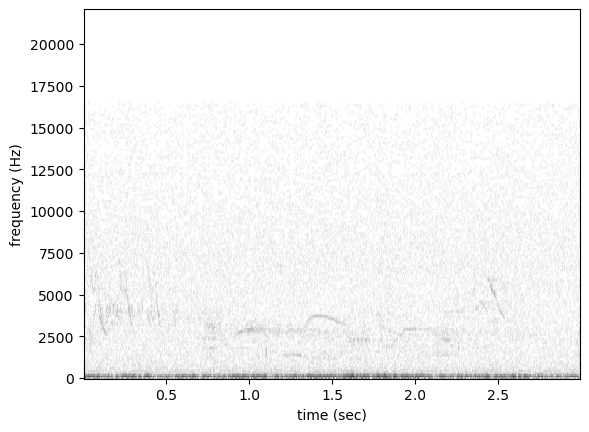

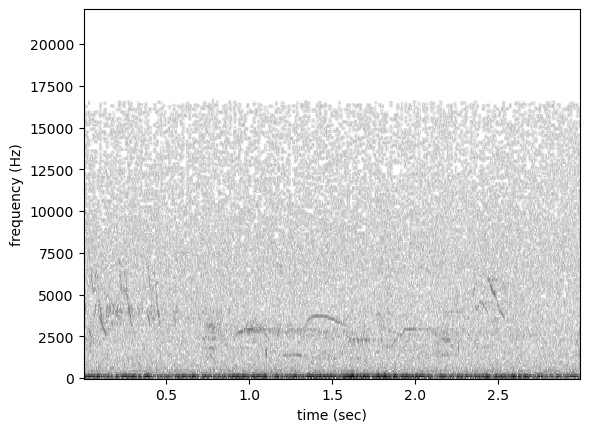

added confidence tag 3 to the dataframe.
verification counts for target_present = 0.0
confidence_cat
0    10474
5       63
3       36
2       23
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:457: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [1178]:
test_df_verified = verify_samples(test_df_verified, ground_truth=0.0, loss_sorted=True)

<Axes: xlabel='confidence_cat'>

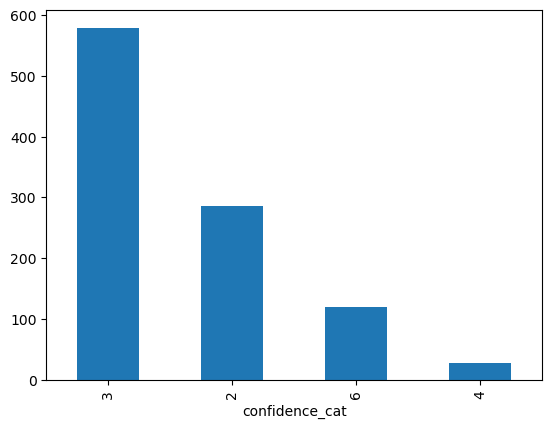

In [1179]:
counts = test_df_verified.loc[test_df_verified.target_present==1.0].confidence_cat.value_counts()
# plot the counts and re-label the x labels with the confidence categories
counts.plot(kind='bar')

- __cat 3__ is confirmed OSFL
- __cat 4__ is focal example
- __cat 6__ is target absent
- __cat 2__ was difficult to descern one way or another. 

The obvious mis-labels should be re-labelled.


After verifying the present samples in the test set, we are left with just under 600 present samples.


# Verify the absent class
The absent class is much larger than the present class, so we'll use a different strategy to clean the samples:
- Go through the samples with the highest loss and re-label those which actually contain the target class. 
- Take a sample of the items in the shuffled validation set equal to the number of present samples available. Verify all of these. 
- This will give us a fully checked training set with equal numbers of samples from each class.
- Additionally we'll have gone through the top section of samples in the validation set which are most likely to have been mis-labelled. 
- Testing the model against this traing set set will give a better feel for how the model will perform in production - since there is likely to be much more absent audio than present audio - these are unlikely to occur at a 50/50 ratio in any case.

target = 0.0, prediction = 0.8399062156677246 loss = 0.8399062156677246


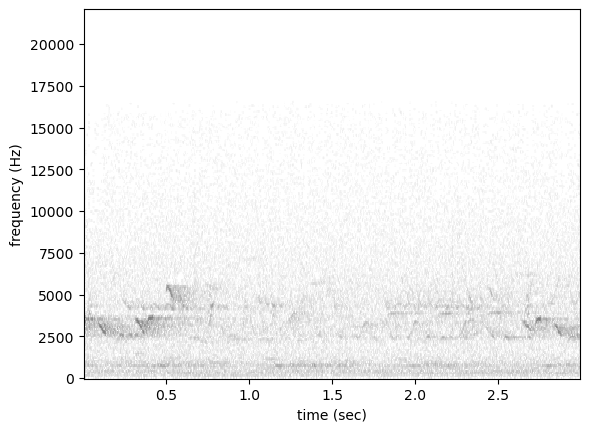

added confidence tag 3 to the dataframe.
confidence_cat
0    8227
3     238
5      69
2      36
1       1
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:385: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [1120]:
test_df_verified = verify_samples(test_df_verified, ground_truth=0.0, loss_sorted=True)

In [1180]:
# plot the counts of verification work on the absent class. 
test_df_verified.loc[test_df_verified.target_present==0.0].confidence_cat.value_counts()

confidence_cat
0    10474
5       63
3       36
2       23
Name: count, dtype: int64

In [1380]:
# Build a balanced test set

n_samples_per_class = 500
# Choose all of the focal present samples
focal_present = test_df_verified.loc[test_df_verified.target_present==1.0].loc[test_df_verified.confidence_cat==4]

# Choose a random sample of the remaining present samples
present = test_df_verified.loc[test_df_verified.target_present==1.0].loc[test_df_verified.confidence_cat==3]
present = pd.concat([focal_present, present.sample(n=n_samples_per_class-len(focal_present))])
print(len(present))

# Choose a random sample of 600 absent samples to verify - knowing that we'll want to end up with 500 and some will be mis-labelled.
absent = test_df_verified.loc[test_df_verified.target_present==0.0].sample(n=n_samples_per_class + 100)

500


In [1975]:
absent = verify_samples(absent, ground_truth=0.0, loss_sorted=True, autolabel=3)

No unverified clips within chosen target class.


# Construct a balanced validation set from equal numbers of verified samples. 

In [1976]:
absent = absent.loc[absent.confidence_cat==3].sample(n=n_samples_per_class, random_state=42)
balanced_test_df = pd.concat([present, absent])

balanced_test_df.target_present.value_counts()

target_present
1.0    500
0.0    500
Name: count, dtype: int64

# Save the verification work to disk

In [1977]:
test_df_verified.to_pickle(data_path / "interim" / "test_set" / "test_set_verified.pkl")
balanced_test_df.to_pickle(data_path / "interim" / "test_set" / "balanced_test_set_verified.pkl")

In [1979]:
test_df_verified.confidence_cat.value_counts()

confidence_cat
0    10474
3      615
2      309
6      119
5       63
4       27
Name: count, dtype: int64

In [1980]:
test_df.target_present.value_counts()

target_present
0.0    10596
1.0     1011
Name: count, dtype: int64

# Concluding notes
We started out with a data set which relied entirely on human labels from wildtrax. Some of these contained errors, so we went through and manually all of the 1000 + present samples, and did some top-down cleaning of the larger absent samples in order to find obvious mis-labels. 

Then a sample of 500 was taken from each class and any which hadn't yet been verified were checked again. 



1. A set of 500 verified present samples and 500 verified  absent samples is saved as __balanced_test_set_verified__

2. A larger set of 10596 absent samples and 1011 present samples is available too. The present samples were all checked, and the absent samples were sorted by highest error between prediction and label (loss), then the top few hundred of these were checked, until the model predictions were below 80% and there were relatively few actual present samples. A confidence category was assigned to these so that they can be re-labelled. This dataset is saved as __test_set_verified__
